In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Imports
import numpy as np
import os
import sys
import pennylane as qml
from pennylane import numpy as pnp
import torch
import torch.nn as nn

## Imports
import os
import sys
import matplotlib

# matplotlib.use('Agg')  # Set the backend to Agg

import matplotlib.pyplot as plt

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "./"))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.poisson.dv_solver import DVPDESolver
from src.poisson.cv_solver import CVPDESolver

# from src.utils.color import model_color
# from src.utils.plot_loss import plot_loss_history
from src.utils.logger import Logging
from src.utils.plotting import plot_results
from math import pi

from src.nn.pde import helmholtz_operator
from src.utils.plot_prediction import plt_prediction
from src.data.helmholtz_dataset import u, f

/okyanus/users/afarea/anaconda3_2021/envs/pennylane_env/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

False

## Generate Testing Dataset


In [6]:
# Test data
num_points = 10
A1 = 1
A2 = 4
LAMBDA = 1.0

dom_coords = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32).to(DEVICE)

t = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)

x = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
t, x = torch.meshgrid(t.squeeze(), x.squeeze())
X_star = torch.hstack((t.flatten().unsqueeze(1), x.flatten().unsqueeze(1))).to(DEVICE)

/okyanus/users/afarea/anaconda3_2021/envs/pennylane_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Load trained model


In [7]:
model_path = (
    "./checkpoints/helmholtz/2025-02-12_00-12-58-340946"  # sim_circ_13_half
              )

In [111]:
data = X_star
solver = "CV"

if solver == "CV":
    state = CVPDESolver.load_state(os.path.join(model_path , "model.pth"))
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])
else:
    state = DVPDESolver.load_state(os.path.join(model_path , "model.pth"))
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])

model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

if "loss_history" in state and len(state["loss_history"]) > 0:
    model.logger.print(f"The final loss: {state['loss_history'][-1]}")
    model.loss_history = state["loss_history"]

model.logger.print(f"Total number of iterations: {len(state['loss_history'])}")

model.model_path = logger.get_output_dir()

total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")

INFO:src.utils.logger:Using GSRandomCVQNN2 
INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 20, 'log_path': './checkpoints/helmholtz', 'input_dim': 2, 'output_dim': 1, 'num_qubits': 2, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [2, 50, 1], 'q_ansatz': 'layered_circuit', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'helmholtz', 'solver': 'CV', 'device': 'cpu', 'method': 'None', 'cutoff_dim': 10, 'class': 'GSRandomCVQNN2', 'encoding': 'angle'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 20
INFO:src.utils.logger:log_path : ./checkpoints/helmholtz
INFO:src.utils.logger:input_dim : 2
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 2
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.l

Model state loaded from ./checkpoints/helmholtz/2025-02-12_00-12-58-340946/model.pth


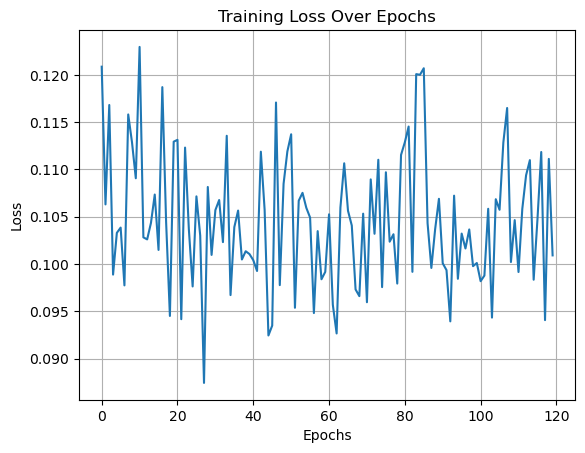

In [112]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)


In [106]:
# Exact solution
u_star = u(X_star, A1, A2)
f_star = f(X_star, A1, A2, LAMBDA)


# Predictions
u_pred_star, f_pred_star = helmholtz_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_exact = u_star.cpu().detach().numpy()
f_exact = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()



# if model.args["solver"] == "CV":
#     u_exact = u_exact / (np.linalg.norm(u_exact) + 1e-8)
#     f_exact = f_exact / (np.linalg.norm(f_exact) + 1e-8)
    # u_pred = u_pred / (np.linalg.norm(u_pred) + 1e-8)
    # f_pred = f_pred / (np.linalg.norm(f_pred) + 1e-8)
    

In [107]:
# Relative L2 error
error_u = np.linalg.norm(u_pred - u_exact, 2) / np.linalg.norm(u_exact, 2) * 100
error_f = np.linalg.norm(f_pred - f_exact, 2) / np.linalg.norm(f_exact, 2) * 100

logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

INFO:src.utils.logger:Relative L2 error_u: 1.63e+02
INFO:src.utils.logger:Relative L2 error_f: 1.00e+02


In [12]:
# INFO:src.utils.logger:Relative L2 error_u: 1.23e+02
# INFO:src.utils.logger:Relative L2 error_f: 1.00e+02

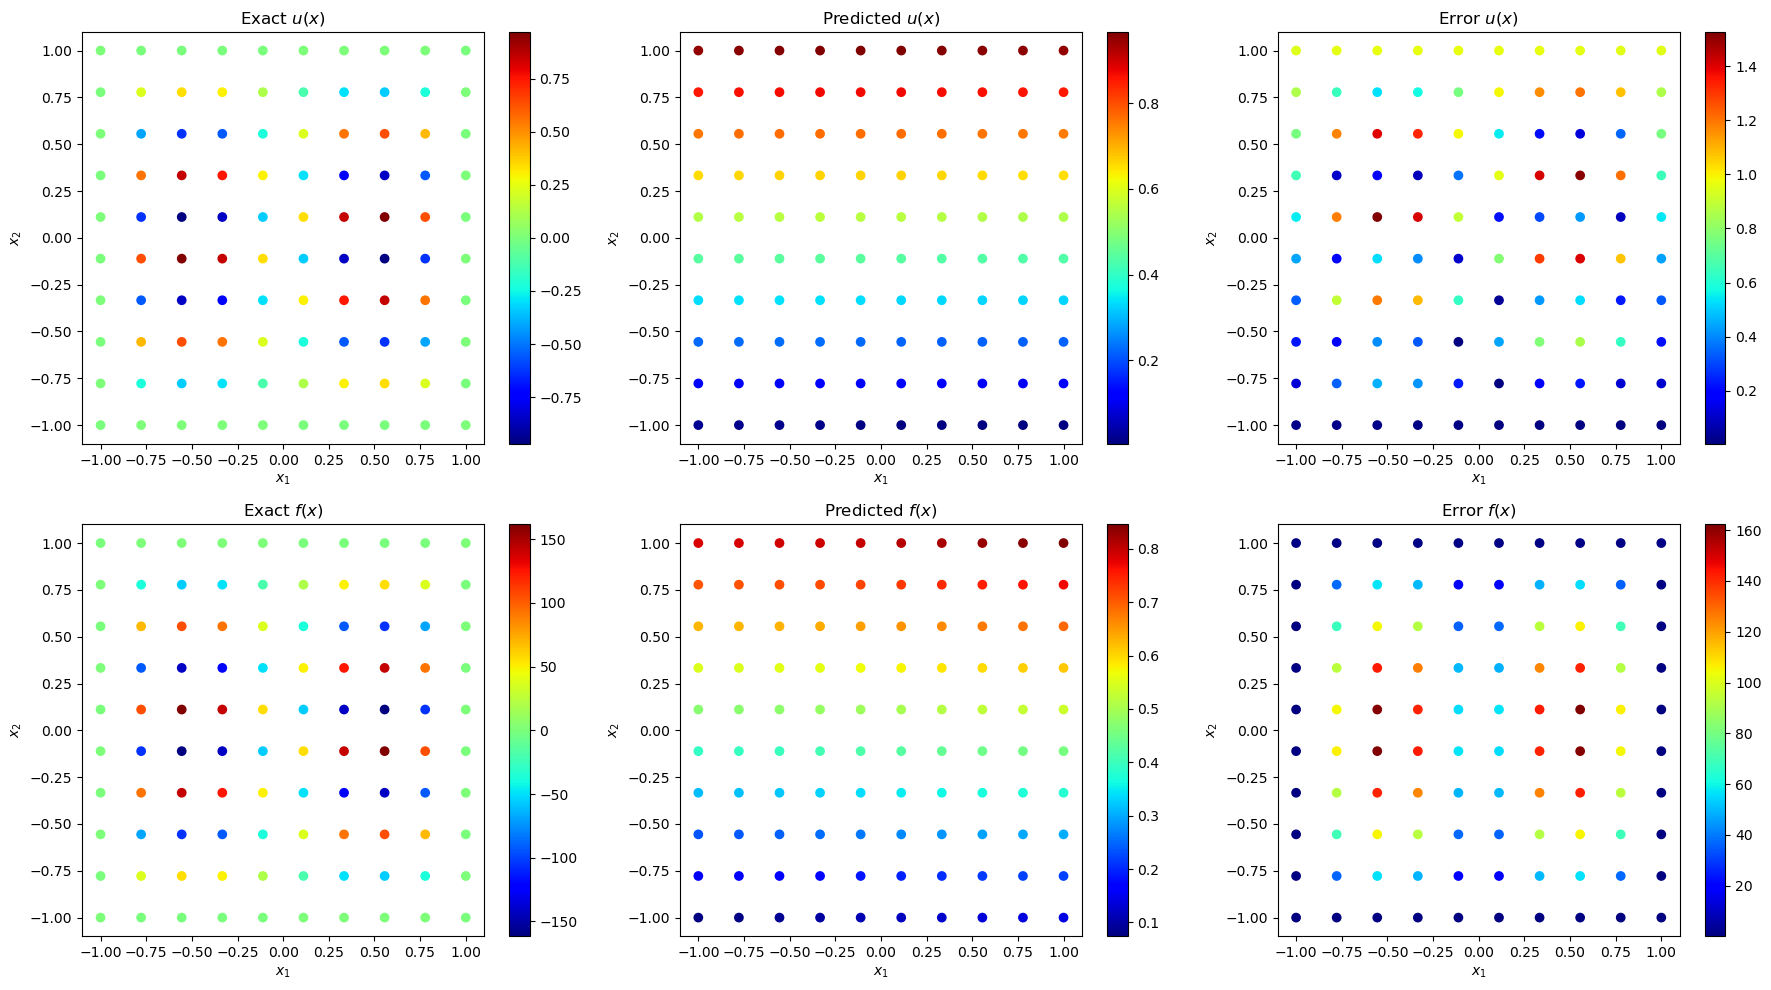

In [108]:
# Plot predictions
plt_prediction(
    logger,
    X,
    u_exact,
    u_pred,
    f_exact,
    f_pred,
)


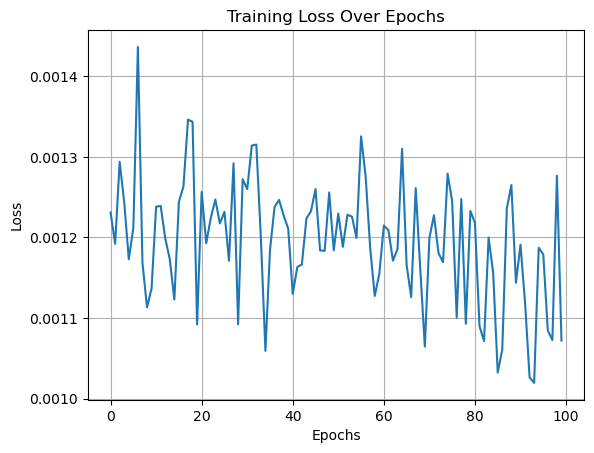

In [14]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)